In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model



list_of_period = [5,10,15,20,25,30]
list_of_k = [1,1.5,2]
period = 20
k = 2

# Read the data from the Excel file
xls_file = '/home/vishi/bolinger/cumul_ohlc.xls'
xls = xlrd.open_workbook(xls_file)
sheet = xls.sheet_by_index(0)
# the sheet is like this 
# DateTime	open	high	low	close
# 20241231~09:16:00	2355950	2356430	2354005	2355135

df = pd.read_excel(xls_file, sheet_name=0, usecols="A:E", header=0)
# Convert the DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d~%H:%M:%S')



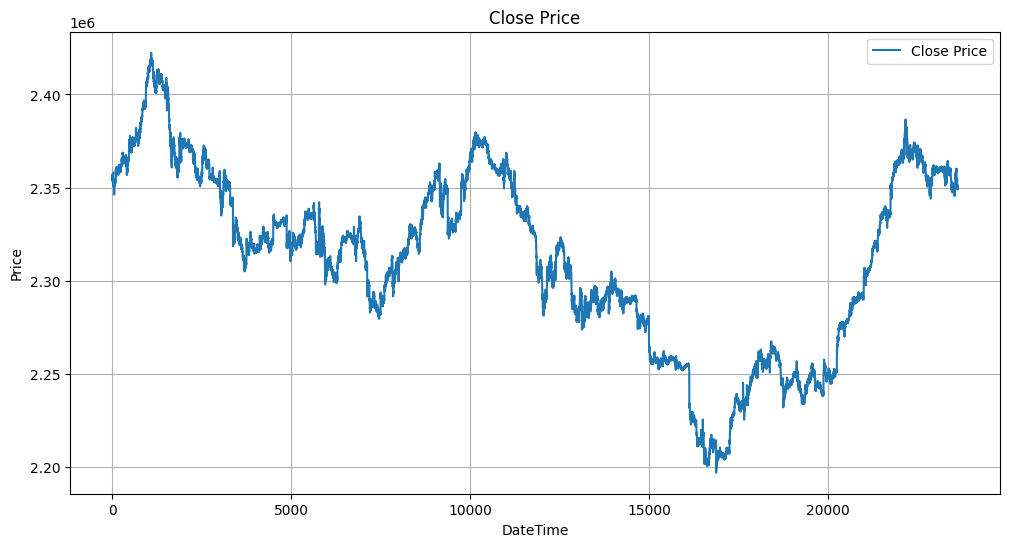

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close Price')
plt.title('Close Price')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [11]:
df['close_diff_percent'] = df['close'].pct_change()* 10000
df['close_moving_avg'] = df['close'].rolling(window=period).mean()
df["std"] = df['close'].rolling(window=period).std()
df["upper_bb"] = df['close_moving_avg'] + k * df["std"]
df["lower_bb"] = df['close_moving_avg'] - k * df["std"]
df['close_diff'] = df['close'].diff()
df['close_scaled_down'] = df['close'] / 1000
df.to_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index=False)

<Figure size 1200x600 with 0 Axes>

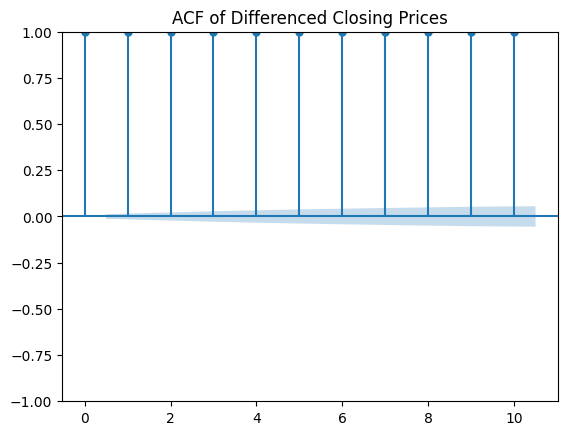

<Figure size 1200x600 with 0 Axes>

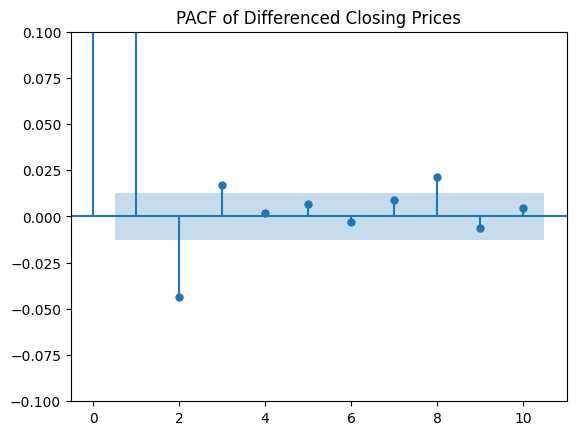

In [12]:
# for the closing price fit an arima model

# find acf and pacf

# remove the lag 0 start from lag 1
plt.figure(figsize=(12, 6))
plot_acf(np.array(df["close"].dropna()), lags=10)
# i want yscale to be between 106-3 to -10^-3
# plt.ylim(-0.1, 0.1)
plt.title('ACF of Differenced Closing Prices')
plt.show()
plt.figure(figsize=(12, 6))
plot_pacf(np.array(df["close"].dropna()), lags=10)
plt.ylim(-0.1, 0.1)

plt.title('PACF of Differenced Closing Prices')
plt.show()


In [17]:
# fit arima model

arima_model = ARIMA(df["close_scaled_down"], order=(0, 1, 1))
# fit the model
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      close_scaled_down   No. Observations:                23625
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -30839.792
Date:                Fri, 23 May 2025   AIC                          61683.585
Time:                        10:27:54   BIC                          61699.725
Sample:                             0   HQIC                         61688.823
                              - 23625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0515      0.004     13.481      0.000       0.044       0.059
sigma2         0.7969      0.001    651.082      0.000       0.795       0.799
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [18]:
residual_from_arima_0_1_1 = arima_fit.resid

# do a lb test
lb_test = acorr_ljungbox(residual_from_arima_0_1_1, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  0.054895        1.0


In [19]:
# do a het test
arch_test = het_arch(residual_from_arima_0_1_1)
print('ARCH Test Statistic:', arch_test[0])
print('ARCH Test p-value:', arch_test[1])

ARCH Test Statistic: 36.14915792686087
ARCH Test p-value: 7.934934998912578e-05


In [22]:
# fit a garch model
garch_model = arch_model(residual_from_arima_0_1_1, vol='Garch', p=1, q=0)
garch_fit = garch_model.fit(disp="off")
print(garch_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -29944.9
Distribution:                  Normal   AIC:                           59895.9
Method:            Maximum Likelihood   BIC:                           59920.1
                                        No. Observations:                23625
Date:                Fri, May 23 2025   Df Residuals:                    23624
Time:                        10:29:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.4223e-03  1.230e-02      0.197      0.844 